# __Scenario A:__<br>Chymotrypsin inhibiton by a *in silico* designed albumin fusion protein

Data provided by Marwa Mohamed (Institute of Cell Biology and Immunology, University of Stuttgart, Germany)

## Project background
In this scenario, the binding of an *in silico* designed protein to an enzyme was assessed by determining the  inhibitory constant $K_{i}$. Thereby, the efficiency of the newly developed approach for computational design of protein binders to deliberately chosen targets was demonstrated. 
This was done by comparing $K_{i}$ of the designed human serum albumin variant (HSA(M3)) to the wild-type (HSA(WT)) by respectively applying the proteins to chymotrypsin enzyme reactions. Both designed proteins were individually dimerized into fusion proteins through a huFc.

### Experimental design

Enzyme activity was monitored by measuring the product formation of p-Nitroanilin (p-NA) photometrically at 410 nm for 30 min at 30°C. Therefore, Succinyl-gly-gly-phe-p-nitroanilide (SGGPpNA) was applied as substrate in a concentration range of 0.25 - 2 mM. For concentration calculations, p-NA standard was prepared in the range of 0 - 0.3 mM in duplicates. $K_{i}$ of HSA(WT)-huFc and HSA(M3)-huFc on chymotrypsin were investigated in independent experiments. Each experiment consisted of enzyme reactions with and without the respective HSA variant. Each enzyme reaction contained 0.2 µM of enzyme and 26.88 µM of the respective HSA variant, if inhibitor was applied. All enzyme reactions were prepared in duplicates.  

### Data management

Experimental data and meta data was filled in EnzymeML Excel templates for each of the two inhibition experiments respectively. Calibration data was stored as Excel files. Measurement data was already blanked.

## Data preparation

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyenzyme as pe
import copy
import string
from IPython.display import display
from EnzymePynetics.tools.parameterestimator import ParameterEstimator
from CaliPytion .tools.standardcurve import StandardCurve

import warnings
warnings.filterwarnings('ignore')

### Concentration calculation

Product standard data was imported directly from an Excel file. Then, a standard curve was created.

Calibration data was automatically blanked.


,AIC
Quadratic,-161
3rd polynominal,-161
Linear,-143
Rational,-141
Exponential,-17


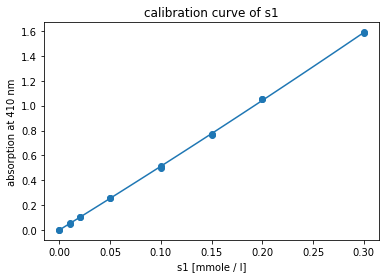

In [2]:
product_standard = StandardCurve.from_excel(
    path="../../data/chymotrypsin_inhibition/pNA-standard.xlsx",
    reactant_id="s1",
    wavelength=410,
    sheet_name="csv", 
    concentration_unit="mmole / l",
    temperature=30,
    temperature_unit="C")
    
product_standard.visualize()

_Fig. 2: Fitted quadratic calibration model to standard data of p-NA._

Based on the Akaike information criterion (AIC), the relation between concentration and absorption is best described by a quadratic function. The calibration measurements and the fitted calibration model are shown in Fig. 2.

### Experimental data

The EnzymeML documents of each experiment were loaded and the standard curve was applied to the absorption data to calculate concentrations.

In [3]:
# Load data from 
chymo_HSAwt = pe.EnzymeMLDocument.fromTemplate("../../data/chymotrypsin_inhibition/chymo_HSAwt.xlsx")
chymo_HSAM3 = pe.EnzymeMLDocument.fromTemplate("../../data/chymotrypsin_inhibition/chymo_HSA(M3).xlsx")

# Apply standard curve to 'EnzymeMLDocument'
chymo_HSAwt = product_standard.apply_to_EnzymeML(chymo_HSAwt, "s1")
chymo_HSAM3 = product_standard.apply_to_EnzymeML(chymo_HSAM3, "s1")

## Comparability of the experiments

Since experimental data with HSA(WT)-huFc and HSA(M3)-huFc originate from independent experiments, the control reactions without the respective inhibitor were compared by performing a parameter estimation (Fig. 3). Thereby, catalytic efficiency $\frac{k_{cat}}{K_{m}}$ was used to assess comparability between the data sets, since $k_{cat}$ and $K_{m}$ were highly correlated (corr > 0.98). High correlations between parameters indicate that the parameters cannot be determined independently with certainty. In this case, the highest initial substrate concentration is presumably too low, compared to the true $K_{m}$ of the enzyme under the given experimental conditions. However, higher substrate concentration were not applied for multiple reasons. On the one hand dimethyl sulfoxide (DMSO) was used as a co-solvent of the substrate, which inhibits enzyme activity {cite:t}`busby1999effect`. Hence, higher initial substrate concentrations would have led to higher enzyme inhibition, which would have distorted the assessment of $K_{i}$.
On the other hand, high substrate viscosity denied the application of higher concentrations without sacrificing pipetting precision.

Kinetic parameters of HSA(wt) chymotrypsin control reactions:


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-1857,56.440 +/- 4.52%,2.226 +/- 7.28%,25.353 +/- 8.57%,-,-
competitive product inhibition,-1856,60.225 +/- 9.01%,2.342 +/- 9.88%,25.714 +/- 13.37%,0.725 +/- 112.65%,-
uncompetitive product inhibition,-1855,57.529 +/- 8.30%,2.276 +/- 10.65%,25.272 +/- 13.50%,-,3.175 +/- 428.92%
substrate inhibition,-1855,56.585 +/- 29.14%,2.233 +/- 35.51%,25.339 +/- 45.93%,-,997.715 +/- 12275.11%
non-competitive product inhibition,-1854,60.110 +/- 9.50%,2.331 +/- 10.00%,25.787 +/- 13.79%,0.702 +/- 117.81%,179.118 +/- 358.38%



Kinetic parameters of HSA(M3) chymotrypsin control reactions:


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
irreversible Michaelis Menten,-549,48.996 +/- 2.23%,1.978 +/- 3.74%,24.776 +/- 4.35%,-,-
competitive product inhibition,-549,51.227 +/- 4.39%,2.043 +/- 4.76%,25.077 +/- 6.47%,0.908 +/- 81.63%,-
uncompetitive product inhibition,-547,49.384 +/- 5.33%,1.996 +/- 6.71%,24.743 +/- 8.57%,-,7.445 +/- 631.41%
non-competitive product inhibition,-547,51.241 +/- 5.62%,2.044 +/- 6.62%,25.073 +/- 8.69%,0.914 +/- 83.56%,121.556 +/- 2156.85%
substrate inhibition,-545,50.368 +/- 3.78%,2.046 +/- 5.12%,24.623 +/- 6.36%,-,87.549 +/- 121.66%


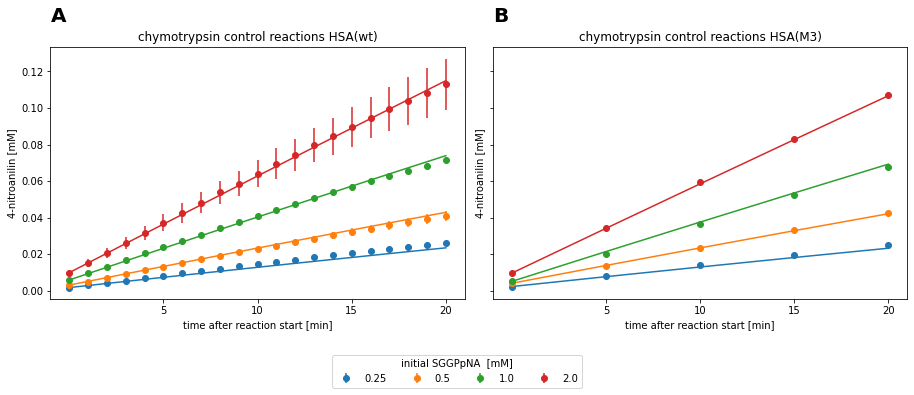

In [4]:
# Create copies of the data sets and delete measurements with inhibitor.
wt_control = copy.deepcopy(chymo_HSAwt)
del wt_control.measurement_dict["m4"]
del wt_control.measurement_dict["m5"]
del wt_control.measurement_dict["m6"]
del wt_control.measurement_dict["m7"]

m3_control = copy.deepcopy(chymo_HSAM3)
del m3_control.measurement_dict["m4"]
del m3_control.measurement_dict["m5"]
del m3_control.measurement_dict["m6"]
del m3_control.measurement_dict["m7"]

# Estimate kinetic parameters of the control reactions of the HSA wild-type data set.
kinetics_wt_control = ParameterEstimator.from_EnzymeML(wt_control, "s1", "product")
kinetics_wt_control.fit_models(stop_time_index=-1, display_output=False)
print("Kinetic parameters of HSA(wt) chymotrypsin control reactions:")
display(kinetics_wt_control.result_dict\
    .style.set_table_attributes('style="font-size: 12px"'))


# Estimate kinetic parameters of the control reactions of the HSA(M3) data set.
kinetics_m3_control = ParameterEstimator.from_EnzymeML(m3_control, "s1", "product")
kinetics_m3_control.fit_models(stop_time_index=-1, display_output=False)
print("\nKinetic parameters of HSA(M3) chymotrypsin control reactions:")
display(kinetics_m3_control.result_dict\
    .style.set_table_attributes('style="font-size: 12px"'))


fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
for e, (doc, ax, title) in enumerate(zip([kinetics_wt_control ,kinetics_m3_control], axes.flatten(), ["chymotrypsin control reactions HSA(wt)", "chymotrypsin control reactions HSA(M3)"])):
    doc.visualize(ax=ax, title=title)
    ax.set_ylabel("4-nitroanilin [mM]")
    ax.set_xlabel("time after reaction start [min]")
    ax.set_xticks([5, 10, 15, 20])
    ax.text(0, 1.1, string.ascii_uppercase[e], transform=ax.transAxes, 
            size=20, weight='bold')

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=4, title="initial SGGPpNA  [mM]", bbox_to_anchor=(0.5,-0.15))
plt.tight_layout()


_Fig. 3: Measurement data and fitted irreversible Michaelis-Menten model for chymotrypsin reactions without HSA inhibitor._

The two dataset were fitted against kinetic models, which are displayed in the tables above. 
Each dataset is best described by the irreversible Michaelis-Menten model in terms of AIC and standard deviation on the estimated parameters. Models with product or substrate inhibition resulted in large uncertanties above 80 % on the parameter estimates. Therefore, irreversible Michaelis-Menten model was utilized for comparison of parameters.  $\frac{k_{cat}}{K_{m}}$ was estimated to be 25.353 min<sup>-1</sup>mM<sup>-1</sup> ± 8.57% for the control reaction of the HSA(WT)-huFc data set and 24.776 min<sup>-1</sup>mM<sup>-1</sup> ± 4.35% for the HSA(M3)-huFc data set. As a result, the two experiments showed to be comparable, since the catalytic efficiency differs less than 3 % between the two data sets.

## Determination and comparison of $K_{i}$

Experimental data of chymotrypsin inhibition by HSA(M3)-huFc contained negative absorption values for the first measurement point. Presumably sourcing from an incorrect blank measurement. Therefore, only measurement data from the second data point (minute 5 and onward) was considered for parameter estimation.
Parameter estimates for all applied kinetic models are displayed in the output below and visualized in Fig. 4.

Kinetic parameters estimates for all models of chymotrypsin inhibition by HSA(WT)-huFc:


,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive inhibition,-3100,22.253 +/- 6.97%,0.460 +/- 27.24%,-
non-competitive inhibition,-3098,22.403 +/- 7.00%,0.449 +/- 27.64%,79.193 +/- 516.52%
irreversible Michaelis Menten,-3088,21.622 +/- 7.15%,-,-
uncompetitive inhibition,-3087,21.631 +/- 7.63%,-,0.696 +/- 88.99%
partially competitive inhibition,-3084,21.643 +/- 8.23%,796.196 +/- 1075.02%,992.685 +/- 48.74%



Kinetic parameters estimates for all models of chymotrypsin inhibition by HSA(M3)-huFc:


,AIC,kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive inhibition,-808,23.031 +/- 10.48%,0.059 +/- 8.51%,-
non-competitive inhibition,-806,23.002 +/- 10.89%,0.060 +/- 9.04%,44.965 +/- 302.77%
uncompetitive inhibition,-751,19.297 +/- 21.77%,-,0.035 +/- 21.33%
irreversible Michaelis Menten,-713,18.512 +/- 24.41%,-,-
partially competitive inhibition,-709,18.544 +/- 27.64%,569.354 +/- 57.96%,925.096 +/- 11733.22%


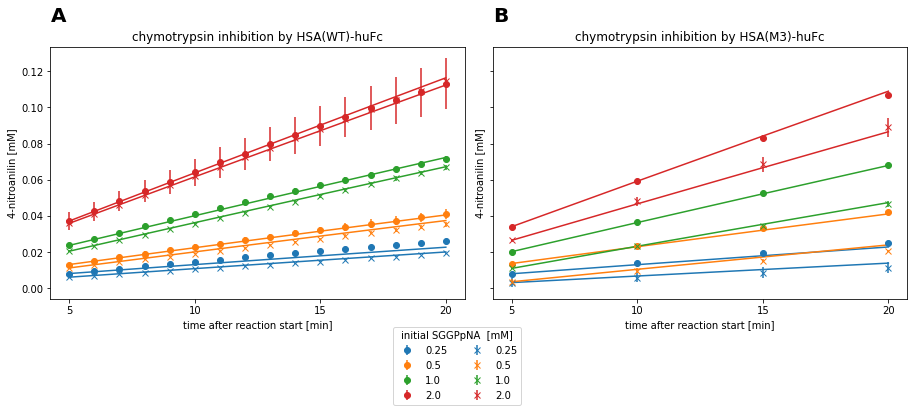

In [5]:
# Parameter estimation for HSA(wt) data set
kinetics_HSAwt = ParameterEstimator.from_EnzymeML(chymo_HSAwt, reactant_id="s1", inhibitor_id="s2", measured_species="product")
kinetics_HSAwt.fit_models(initial_substrate_concs=[0.25, 0.5, 1, 2], stop_time_index=-1, start_time_index=5, display_output=False)
print("Kinetic parameters estimates for all models of chymotrypsin inhibition by HSA(WT)-huFc:")
display(kinetics_HSAwt.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"])\
    .style.set_table_attributes('style="font-size: 12px"'))

# Parameter estimation for HSA(M3) data set
kinetics_HSAM3 = ParameterEstimator.from_EnzymeML(chymo_HSAM3, reactant_id="s1", inhibitor_id="s3", measured_species="product")
kinetics_HSAM3.fit_models(initial_substrate_concs=[0.25, 0.5, 1, 2], stop_time_index=-1, start_time_index=1, display_output=False)
print("\nKinetic parameters estimates for all models of chymotrypsin inhibition by HSA(M3)-huFc:")
display(kinetics_HSAM3.result_dict.drop(columns=["kcat [1/min]", "Km [mmole / l]"])\
    .style.set_table_attributes('style="font-size: 12px"'))

# Visualize experimental data and fitted models
fig, axes = plt.subplots(1,2, figsize=(12.8,4.8), sharey=True, sharex=True)
for e, (doc, ax, title) in enumerate(zip([kinetics_HSAwt ,kinetics_HSAM3], axes.flatten(), ["chymotrypsin inhibition by HSA(WT)-huFc", "chymotrypsin inhibition by HSA(M3)-huFc"])):
    doc.visualize(ax=ax, title=title)
    ax.set_ylabel("4-nitroanilin [mM]")
    ax.set_xlabel("time after reaction start [min]")
    ax.set_xticks([5, 10, 15, 20])
    ax.text(0, 1.1, string.ascii_uppercase[e], transform=ax.transAxes, 
            size=20, weight='bold')

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=2, title="initial SGGPpNA  [mM]", bbox_to_anchor=(0.5,-0.2))
plt.tight_layout()

_Fig. 4: Measurement data and fitted product inhibition model for chymotrypsin reactions with respective HSA inhibitior._

Both reaction systems are best described by the competitive inhibition model, which is indicated by the lowest AIC and standard deviation on the estimated parameters. Thereby, a $K_{i}$ of 0.460 mM ± 27.24% was estimated for HSA(WT)-huFc and 0.059 mM ± 8.51% for HSA(M3)-huFc. This resembles a roughly 7-fold increase in affinity of HSA(M3) to the enzyme compared to the HSA(wt). 
Since the competitive inhibition model describes the data the best, HSA(M3)-huFc presumably interacts with the enzyme in the active site region.  

## Save modeling results

Lastly, the modeling results are written to the EnzymeML documents and the files are exported.

In [6]:
for result, enzmldoc in zip([kinetics_HSAwt, kinetics_HSAM3], [chymo_HSAwt, chymo_HSAM3]):

    # Write modeling results to kinetic parameters
    k_cat = pe.enzymeml.models.KineticParameter(
        name="k_cat",
        value=result.get_model_results()["k_cat"].value,
        unit=f"1 / {result.data.time_unit}")

    K_m = pe.enzymeml.models.KineticParameter(
        name="K_m",
        value=result.get_model_results()["Km"].value,
        unit=result.data.data_conc_unit)

    K_ic = pe.enzymeml.models.KineticParameter(
        name="K_ic",
        value=result.get_model_results()["K_ic"].value,
        unit=result.data.data_conc_unit)

    # Define kinetic model
    model = pe.KineticModel(
        name="competitive inhibition",
        equation="-k_cat * p0 * s0 / (K_m*(1+(s2 / K_ic))+s0)",
        parameters=[k_cat, K_m, K_ic])

    enzmldoc.getReaction("r0").model = model

    # Export EnzymeML documents
    export = False
    if export:
        enzmldoc.toFile()